In [23]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import copy
import matplotlib.pyplot as plt
import numpy as np
import torch

# Pedestrian Path Prediction Problem

Given: past $(x, y)$ coordinates of a pedestrian<br />
Looking for: future $(x, y)$ coordinates

Pedestrian path prediction is inherently a non-deterministic process because the pedestrian has free will and is always able to make free choices that cannot be deduced from external variables. The problem must be solved in a statistical framework where multiple future choices are possible.


### Simplified Problem

The pedestrian just moves in one dimension $x$ and is currently at $x=0$. In the training data, in 33% of all cases, the pedestrian goes to $x=-1$ and in the remaining cases goes to $x=1$. We are only looking at a single step.

While the data is discrete, we want to investigate methods that generalize to arbitrary coordinates, so we will only investigate methods that regress to output locations in a continuous way (_i.e._, we are not going to look at discrete choices between -1 and 1).


### Models

We already know deterministic models won't work. 

The `Simple` model below is a "simple" extension to a deterministic feed-forward Neural Network with an additional randomly sampled input. The random input makes the model non-deterministic. However, we don't have a learning method that leverages the random input and so these models produce similar results as their deterministic equivalents.

One way to train a posterior distribution that leverages random sampling is with VAEs which are explored below.

In [24]:
class Simple(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = torch.nn.Linear(1, 50)
        self.fc2 = torch.nn.Linear(50, 1)
        
    def forward(self, x):
        r = torch.randn((x.shape[0], 1))
        x = torch.nn.functional.relu(self.fc1(r))
        return self.fc2(x)

model = Simple()
model_init = copy.deepcopy(model.state_dict())

x_train = torch.zeros((1000, 1), requires_grad=False)
x_pred = torch.zeros((1000000, 1), requires_grad=False)
target = torch.ones((1000, 1), requires_grad=False)
target[::3] = -1.0
print(target[:5])

tensor([[-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.]])


# Training

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model.load_state_dict(model_init)
for epoch in range(10000):
    optimizer.zero_grad()
    loss = torch.nn.functional.l1_loss(model(x_train), target)
    loss.backward()
    optimizer.step()
    
predicted_l1 = model(x_pred)
print(predicted_l1[:10])

tensor([[1.0031],
        [1.0027],
        [1.0043],
        [0.9992],
        [0.9987],
        [1.0016],
        [1.0072],
        [1.0009],
        [1.0046],
        [0.9958]], grad_fn=<SliceBackward>)


In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

model.load_state_dict(model_init)
for epoch in range(10000):
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(model(x_train), target)
    loss.backward()
    optimizer.step()
    
predicted_mse = model(x_pred)

# Analysis

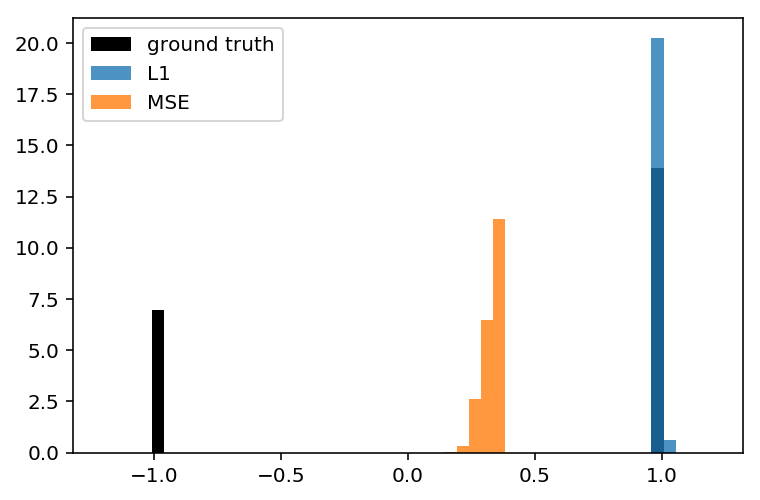

In [27]:
fig, ax = plt.subplots()
ax.hist(target.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, label='ground truth', color='black')
ax.hist(predicted_l1.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='L1')
ax.hist(predicted_mse.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='MSE')
ax.legend()
plt.show()

# VAE model

In [28]:
class VAE(torch.nn.Module):
    """Based on the pytorch VAE example."""
    
    def __init__(self):
        super().__init__()

        # encoder
        self.fc1 = torch.nn.Linear(1, 20)
        self.fc21 = torch.nn.Linear(20, 2)
        self.fc22 = torch.nn.Linear(20, 2)
        
        # decoder
        self.fc3 = torch.nn.Linear(2, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, 1)

    def encode(self, x):
        h1 = torch.nn.functional.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.nn.functional.relu(self.fc3(z))
        h4 = torch.nn.functional.relu(self.fc4(h3))
        return self.fc5(h4)

    def forward(self, x):
        if self.training:
            mu, logvar = self.encode(x)
        else:
            mu = torch.zeros((x.shape[0], 2), requires_grad=False)
            logvar = torch.zeros((x.shape[0], 2), requires_grad=False)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
vae_model = VAE()
vae_model_init = copy.deepcopy(vae_model.state_dict())

In [35]:
def vae_loss_mse(y_hat, target, mu, logvar, *, kld_prefactor=1.0):
    recon_loss = torch.nn.functional.mse_loss(y_hat, target, reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / y_hat.shape[0]

    return recon_loss + kld_prefactor * KLD

def vae_loss_l1(y_hat, target, mu, logvar, *, kld_prefactor=1.0):
    recon_loss = torch.nn.functional.l1_loss(y_hat, target, reduction='mean')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / y_hat.shape[0]

    return recon_loss + kld_prefactor * KLD

In [29]:
vae_model.load_state_dict(vae_model_init)
vae_model.train()
optimizer = torch.optim.SGD(vae_model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10000):
    optimizer.zero_grad()
    y_hat, mu, logvar = vae_model(target)
    loss = vae_loss_mse(y_hat, target, mu, logvar, kld_prefactor=2.0)
    loss.backward()
    optimizer.step()

In [30]:
vae_model.eval()
predicted_vae, _, __ = vae_model(x_pred)
print(predicted_vae[:10])

tensor([[0.4040],
        [0.3465],
        [0.3221],
        [0.3304],
        [0.3201],
        [0.3198],
        [0.3199],
        [0.3370],
        [0.3224],
        [0.3199]], grad_fn=<SliceBackward>)


In [31]:
vae_model_lowkl = VAE()
vae_model_lowkl.load_state_dict(vae_model_init)
vae_model_lowkl.train()
optimizer = torch.optim.SGD(vae_model_lowkl.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10000):
    optimizer.zero_grad()
    y_hat, mu, logvar = vae_model_lowkl(target)
    loss = vae_loss_mse(y_hat, target, mu, logvar, kld_prefactor=0.1)
    loss.backward()
    optimizer.step()

vae_model_lowkl.eval()
predicted_vae_lowkl, _, __ = vae_model_lowkl(x_pred)

In [41]:
vae_model_l1 = VAE()
vae_model_l1.load_state_dict(vae_model_init)
vae_model_l1.train()
optimizer = torch.optim.SGD(vae_model_l1.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10000):
    optimizer.zero_grad()
    y_hat, mu, logvar = vae_model_l1(target)
    loss = vae_loss_l1(y_hat, target, mu, logvar, kld_prefactor=2.1)
    loss.backward()
    optimizer.step()

vae_model_l1.eval()
predicted_vae_l1, _, __ = vae_model_l1(x_pred)

In [45]:
vae_model_lowkl_l1 = VAE()
vae_model_lowkl_l1.load_state_dict(vae_model_init)
vae_model_lowkl_l1.train()
optimizer = torch.optim.SGD(vae_model_lowkl_l1.parameters(), lr=0.01, momentum=0.9)
for epoch in range(10000):
    optimizer.zero_grad()
    y_hat, mu, logvar = vae_model_lowkl_l1(target)
    loss = vae_loss_l1(y_hat, target, mu, logvar, kld_prefactor=0.1)
    loss.backward()
    optimizer.step()

vae_model_lowkl_l1.eval()
predicted_vae_lowkl_l1, _, __ = vae_model_lowkl_l1(x_pred)

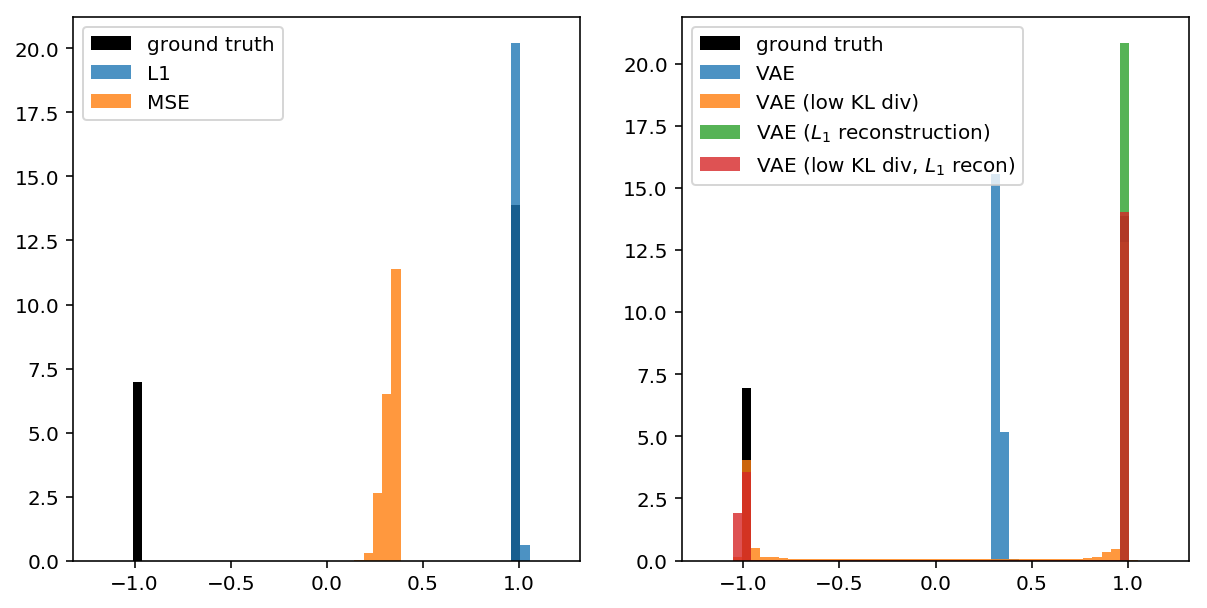

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

ax1.hist(target.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, label='ground truth', color='black')
ax1.hist(predicted_l1.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='L1')
ax1.hist(predicted_mse.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='MSE')
ax1.legend()

ax2.hist(target.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, label='ground truth', color='black')
ax2.hist(predicted_vae.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='VAE')
ax2.hist(predicted_vae_lowkl.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='VAE (low KL div)')
ax2.hist(predicted_vae_l1.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='VAE ($L_1$ reconstruction)')
ax2.hist(predicted_vae_lowkl_l1.detach().numpy(), bins=50, range=(-1.2, 1.2), density=True, alpha=0.8, label='VAE (low KL div, $L_1$ recon)')
ax2.legend()

plt.show()

# Conclusions

__Reconstruction loss__: MSE tends to produce results in between the two modes. L1 collapses onto the dominant mode.

__KL strength in VAE models__: VAE models reproduce the full posterior distribution unless the KL strength is too large in which case the models revert to their deterministic behavior (averaging for MSE, collapse for L1).

# References

Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).

Sohn, Kihyuk, Honglak Lee, and Xinchen Yan. "Learning structured output representation using deep conditional generative models." Advances in neural information processing systems. 2015.

Yan, Xinchen, et al. "Mt-vae: Learning motion transformations to generate multimodal human dynamics." Proceedings of the European Conference on Computer Vision (ECCV). 2018.